# Term project 3553:data processing

[Step 1: Goal](#H1)  
[Step 2:Exploratory Data](#H2)  
>[Check outlier](#H3)  
[remove extreme value in y and get monthly value for x](#H4)  
[Convert y data to category.](#H5)  

[Step 3: Store data](#H6)  
[Step 4: Explore the data by clustering model - kMeans](#H7) 

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

In [2]:
import os
"""Load the data from the data file folder.
Data is saved by {each ticker's name}.csv.
When pass the folder path, and the year, return value is a dataframe for all the nasdaq 
stock  daily adjusted close price for that year. 
Parameters:
    path (str): the folder where data were stored. i.e. "p_data/"
    year(str): year in string. 
Returns: 
    data(DataFrame): dataframe contains the stock data for the year. 
"""
def load_data(path, year):
    data = pd.DataFrame(data={})
    for x in os.listdir(path):
        temp = pd.read_csv(path + x, encoding='utf-8')
        temp = temp.set_index('date')
        
        # select the close price for the year, for example. 
        # chose split adjusted price.
        temp = pd.DataFrame(temp.filter(like=year, axis=0).loc[:,'5. adjusted close'])
        old_r_name=temp.columns[0]
        temp = temp.T.rename(index={old_r_name: x[:-4]})
        data = data.append(temp, sort = True)
    return data

"""
get the x dataframe and y series with same row number.

Parameters:
    folder (str): the folder where data were stored. i.e. "p_data/"
    x_year(str): year in string. 
    x_year_end (str): used if more than one year's data is needed. 
Returns: 
    x(DataFrame): dataframe contains the stock data for the year. 
    y(Series): target value contains the stock return for the year after x_year_end.

"""
def get_xy(folder, x_year, x_year_end = 0):

    #case 1: x year is only one year.
    #case 2: x year is over one year. 
    
    
    
    #case 2
    x = pd.DataFrame()
    if x_year_end != 0:
        last_year = x_year_end
        for year in range (int(x_year), int(x_year_end) + 1):
            temp = load_data(folder, str(year))
            x = x.join(temp, how='right')
    else:
        #case 1 now.
        x = load_data(folder, x_year)
        last_year = x_year
    
    x = x.dropna() 
    
    target_data = load_data(folder, str(int(last_year) + 1))
    #get only data where x has data
    target_data =target_data.filter(items = x.index, axis = 0)
    
    year_end_price = target_data.iloc[:,-1]
    year_start_price = target_data.iloc[:,0]
    y = year_end_price.div(year_start_price)
    
    y.name = "target"
    data = x.join(y).dropna()
    y = data.iloc[:,-1]
    x = data.drop(columns='target')
    
    return x, y


"""
convert the data column into datatimeindex of DataFrame
assume: x.row_index is stock ticker symbole and x.column_index is data time string.

Parameters:
    x(DataFrame): dataframe contains the stock data for the year. 
Returns: 
    x(DataFrame): dataframe contains the stock data for the year, with DateTimeIndex for column
   
"""

def convert_dateindex(x):
    new_columns = [d.date() for d in pd.to_datetime(x.columns)]  #convert to columns = datatime object
    x_trans = x.T               
    x_trans = x_trans.set_index(pd.DatetimeIndex(new_columns))
    x = x_trans.T  
    return x


#works on time-series data with datatime as column. 
"""
resample the stock data by month. 

Parameters:
    x(DataFrame): dataframe contains the stock data. 
Returns: 
    x(DataFrame): dataframe contains the stock's monthly data.
   
"""

def get_monthly_x(x):
    
    #resample only works on index
    x_month = x.T.resample("M").mean().T
    return x_month

In [4]:
FOLDER = "p_data/"
x, y = get_xy(FOLDER, "2014", "2015")
x2, y2 = get_xy(FOLDER, "2016","2017")

In [5]:
print(x.shape)
print(y.shape)

(1929, 504)
(1929,)


In [7]:
x = convert_dateindex(x)
x2 = convert_dateindex(x2)

<a id="H1"></a>
# Step 1: Goal
Our data is nasdaq's stock data for 2014. our goal is to identify profitable stocks for next year based on previous year's stock data. In this case, we choose to work on 2014 data. 

<a id="H2"></a>
# Step 2: Explore the data

As we are not quite familiar with the data, I would like to do clustering technique on the dataset to get a understanding of the data. My goal is to identify profitable stocks for long-term investment purposes. Regression analysis is not a good option. 

My reasoning for doing clustering is to group stocks based on the trend of the stock price. Maybe the upward stocks prices can be clustered into one group. Then from that group, I could do more work. 

In [8]:
x.head()

,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,2014-01-13 00:00:00,2014-01-14 00:00:00,2014-01-15 00:00:00,...,2015-12-17 00:00:00,2015-12-18 00:00:00,2015-12-21 00:00:00,2015-12-22 00:00:00,2015-12-23 00:00:00,2015-12-24 00:00:00,2015-12-28 00:00:00,2015-12-29 00:00:00,2015-12-30 00:00:00,2015-12-31 00:00:00
AABA,39.5900,40.1200,39.9300,40.9200,41.0200,40.9200,41.2300,39.9900,41.1400,41.0700,...,33.2300,32.9500,32.9650,34.1900,34.4500,34.1100,33.6000,34.0400,33.3700,33.2600
AAL,24.1500,25.2737,25.7403,25.6213,26.3117,28.0163,27.9496,27.2830,27.4925,27.4640,...,40.9911,39.6685,40.9331,41.4110,41.7924,42.2944,41.7344,41.9951,41.3193,40.8849
AAME,3.8262,3.9119,3.8687,3.8831,3.8543,3.8735,3.8639,3.8927,3.8927,3.8639,...,4.5784,4.6272,4.6272,4.6077,4.6174,4.6272,4.6077,4.8615,4.7541,4.8712
AAOI,14.6300,14.3500,14.3300,14.7400,14.6600,14.1600,14.0000,13.7000,13.8800,13.9700,...,16.8700,16.9200,17.0000,16.9200,17.1200,17.5800,17.5600,18.0400,17.8000,17.1600
AAON,20.2004,20.1940,19.8689,20.1558,20.2450,20.1239,20.0283,19.7159,20.0538,20.6530,...,22.4529,22.1416,22.2291,22.4724,22.5794,23.0366,22.8809,22.8809,23.0269,22.5891


In [9]:
x.shape

(1929, 504)

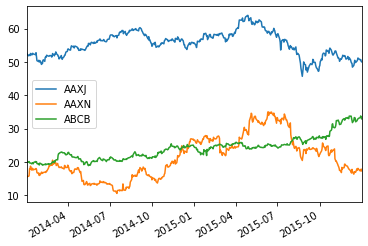

In [12]:
data_example = x.iloc[7:10].T
data_example.plot()
plt.show()

Based on the above graph, we would like to predict stocks like AAPL and AAL with a upward trend through out the year. 

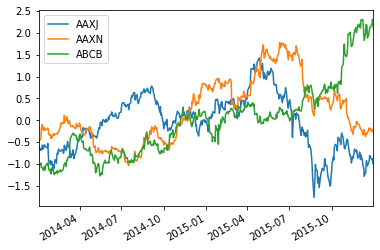

In [13]:


scaled_example = pd.DataFrame(scaler.fit_transform(data_example), index = data_example.index, columns = data_example.columns)
scaled_example.plot()
plt.show()

In [ ]:
scaled_example.head()

<a id="H3"></a>
## check outlier

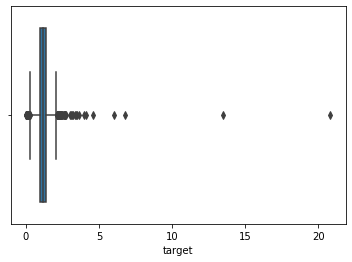

In [14]:
import seaborn as sns
sns.boxplot(y)

In [15]:
#drop extreme value

def detect_outlier(data_1):
    outliers=[]
    threshold=2.89
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

#drop extremem value based on y value from the dataset.
#requirement: x and y has same index name.
def drop_extreme_y(x,y):
    
    outliers = detect_outlier(y)
    outlier_index = x[y.isin(detect_outlier(y))].index
    x = x.drop(index = outlier_index)
    y = y.drop(index = outlier_index)
    return x, y

In [16]:
outlier_index = x[y.isin(detect_outlier(y))].index

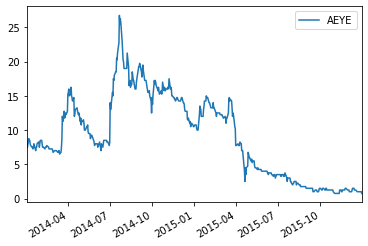

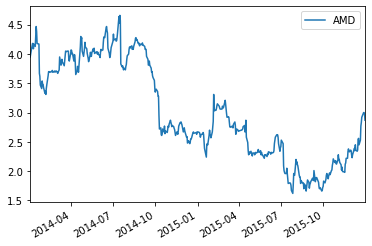

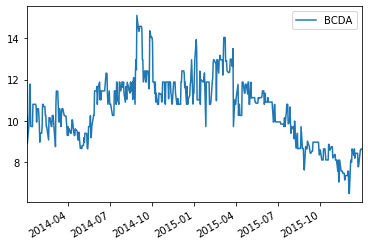

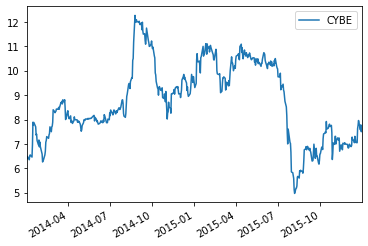

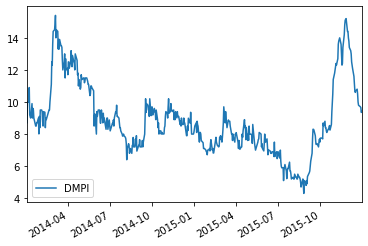

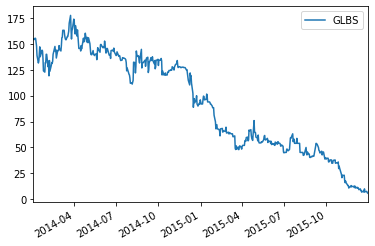

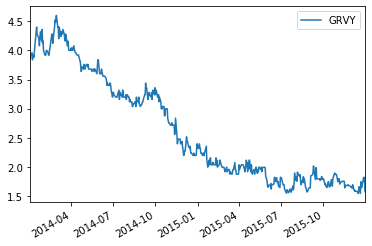

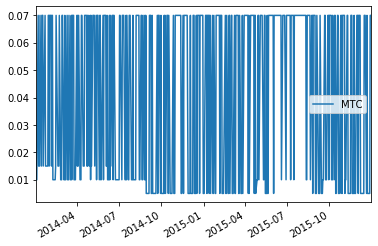

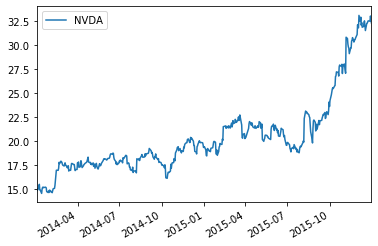

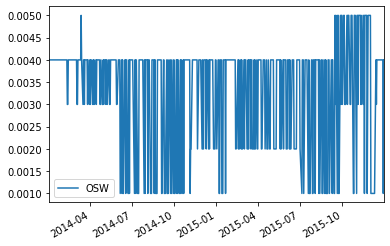

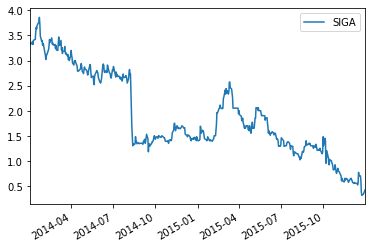

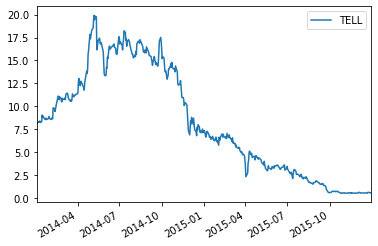

In [17]:
for i in outlier_index:
    x.loc[i].plot(legend=True)
    plt.show()

<a id="H4"></a>
## remove extreme value in y and get monthly value for x

In [18]:
x, y = drop_extreme_y(x,y)
x2, y2 = drop_extreme_y(x2, y2)
x_month = get_monthly_x(x)  # convert monthly value after drop outlier
x2_month = get_monthly_x(x2) 

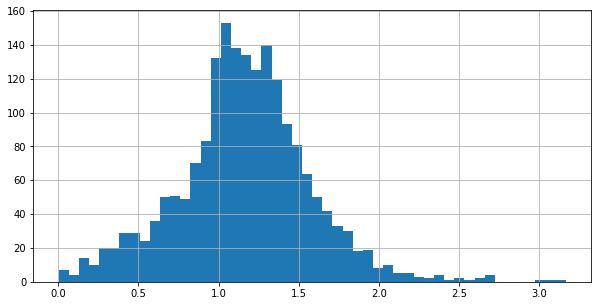

In [22]:
y.hist(bins=50, figsize=(10,5)) #after remove outlier.

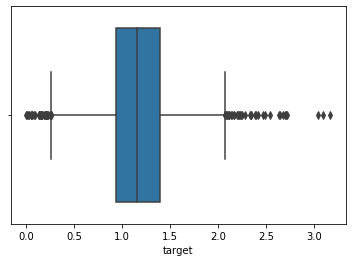

In [20]:
sns.boxplot(y)

<a id="H5"></a>
## Convert y data to category. 

In [23]:
def convert_cat(y):
    y_cat = 1*np.ravel(y > y.quantile(.75))
    y_cat = pd.Series(y_cat, index = y.index)
    return y_cat

y_cat = convert_cat(y)
y2_cat = convert_cat(y2)

In [24]:
y_cat.head()

AABA    0
AAL     0
AAME    0
AAOI    1
AAON    1
dtype: int32

<a id="H6"></a>
# Step 3: Store data

In [25]:
%store x
%store x2
%store y
%store y2
%store y_cat
%store y2_cat
%store x_month
%store x2_month

Stored 'x' (DataFrame)
Stored 'x2' (DataFrame)
Stored 'y' (Series)
Stored 'y2' (Series)
Stored 'y_cat' (Series)
Stored 'y2_cat' (Series)
Stored 'x_month' (DataFrame)
Stored 'x2_month' (DataFrame)


<a id="H7"></a>
# Step 4: Explore the data by clustering model - kMeans

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia




In [29]:
X = scaler.fit_transform(x)
inertias_1 = []
silhouette_avgs = []
max_K = 30
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    # train K Means. 
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

In [30]:
inertias_1

[264739656669308.47,
 7179529912.33423,
 1944357020.2021487,
 614344097.7758065,
 252077523.39707032,
 141684111.77146202,
 90241476.74041831,
 49739528.92902985,
 30575186.311833087,
 23815109.420846246,
 17122688.527459953,
 8096138.891065673,
 3850794.261397069,
 2192387.1693015047,
 1608447.3108668104,
 1329054.17276549,
 1087733.608065631,
 877419.5206315558,
 797255.2834565911,
 684541.5155120658,
 599732.4174567523,
 555568.4283227744,
 508213.67163737165,
 462346.47572041734,
 423418.07089393475,
 386241.409939945,
 351139.18904022116,
 329677.04038187873,
 295760.4217315672,
 286744.3497802863]

In [31]:
silhouette_avgs[15]

0.6608107045164917

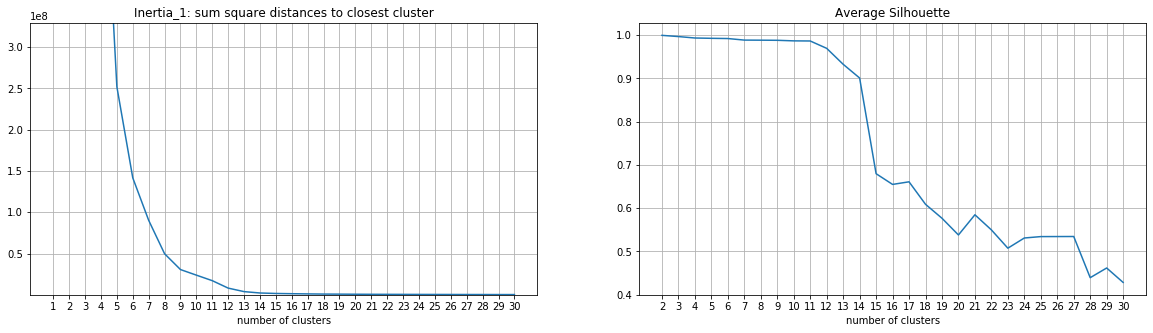

In [32]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.ylim(top =  329266943, bottom = 1000)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,2,2)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

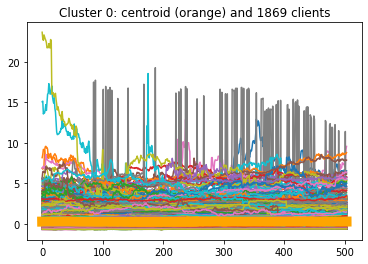

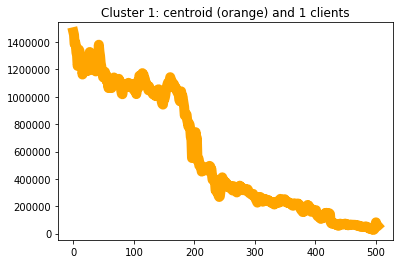

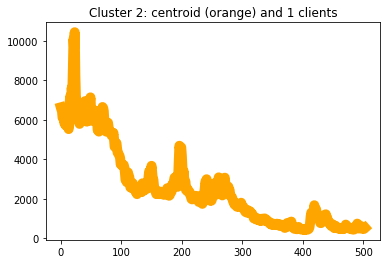

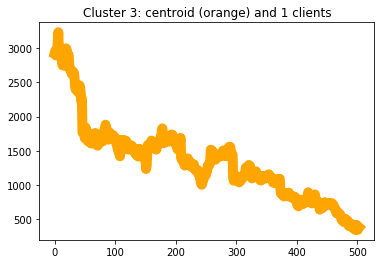

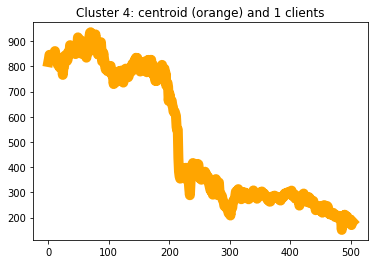

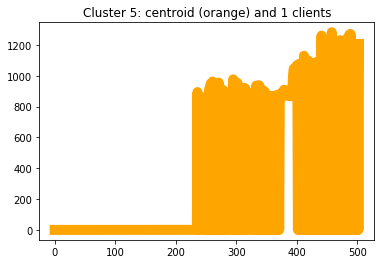

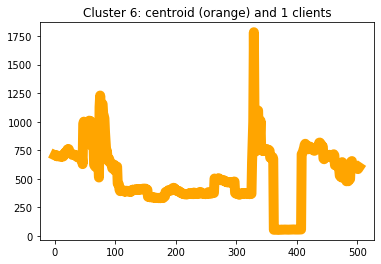

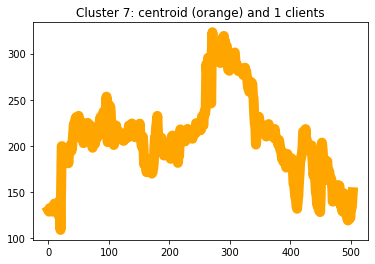

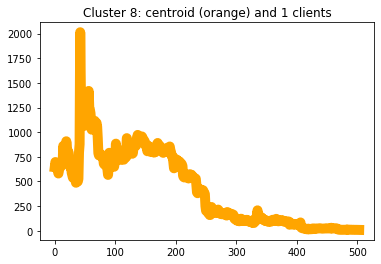

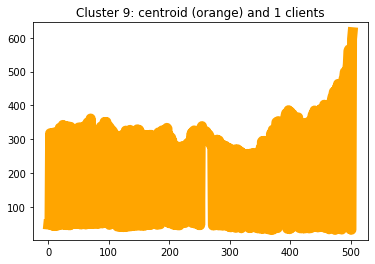

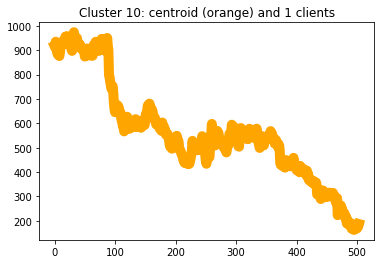

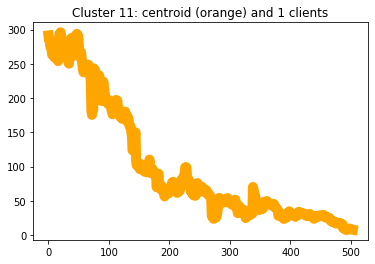

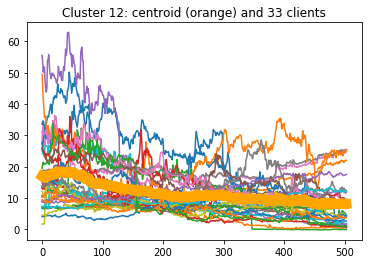

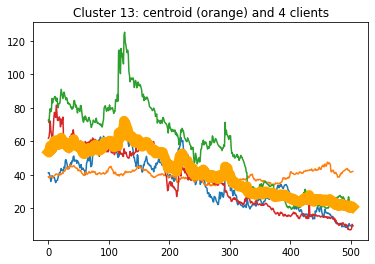

In [34]:
K = 14 # the desired value
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)  # re-train

# Plots
for c in range(K) :    
    plt.plot(X[kmeans.labels_==c].T)
    plt.plot(kmeans.cluster_centers_[c], linewidth=10, color='orange')
    plt.title("Cluster "+str(c)+": centroid (orange) and "+str(sum(kmeans.labels_==c))+" clients")
    plt.show()

#### Based on the result, there are a lot of outlier in the data.

## Try DBSCAN

In [35]:
from sklearn.cluster import DBSCAN
from sklearn import metrics


dbscan = DBSCAN(eps=5,min_samples=2).fit(X)



In [36]:
def score_dbscan(dbscan):
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  #3 - 1
    n_noise_ = list(labels).count(-1)

    """
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))
    """
    metric = metrics.silhouette_score(X, labels)
    
    return n_clusters_, n_noise_, metric

In [37]:
score_dbscan(dbscan)

(8, 210, 0.1338342850556252)

In [38]:
x_p = dbscan.fit_predict(X)



In [39]:
labels = pd.Series(dbscan.labels_)
labels.value_counts()


 0    1690
-1     210
 5       5
 7       2
 6       2
 4       2
 3       2
 2       2
 1       2
dtype: int64

number of stocks in this cluster is  1690


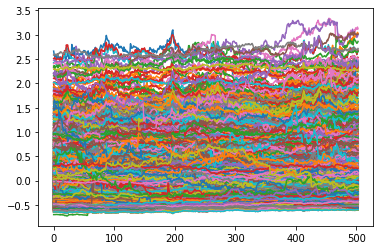

number of stocks in this cluster is  2


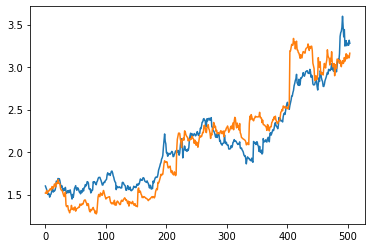

number of stocks in this cluster is  2


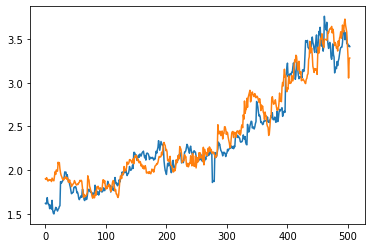

number of stocks in this cluster is  2


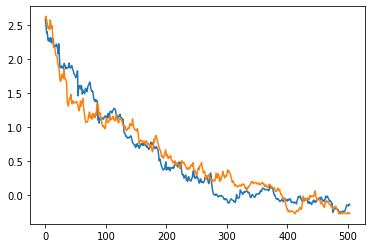

number of stocks in this cluster is  2


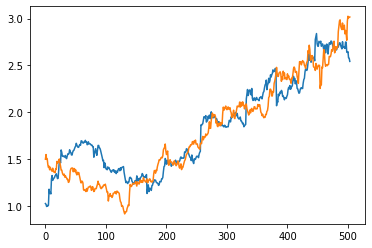

number of stocks in this cluster is  5


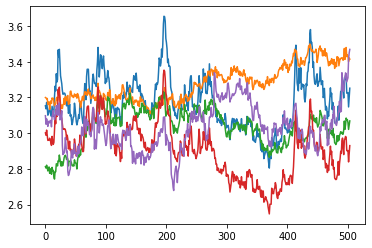

number of stocks in this cluster is  2


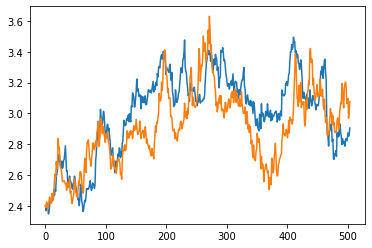

number of stocks in this cluster is  2


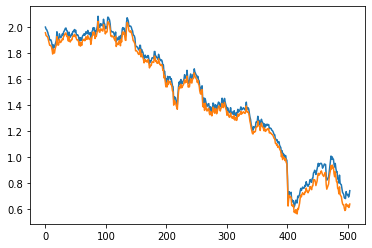

In [43]:
n_clusters = len(set(dbscan.labels_)) - 1
for c in range(n_clusters) :    
    plt.plot(X[x_p==c].T)
    print("number of stocks in this cluster is ", len(X[x_p == c]))
    plt.show()


#### Based on the result, it seems there is actually one pattern in the data, just the a straight line. 

In [ ]:
#using grid search to see if we could find best cluster option using DBSCAN

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


eps = [1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 3,4,5] 
min_samples = [2,3,4,5,6,7,8]

data = np.zeros([1,5])

for i in eps:
    for j in min_samples:
        dbscan = DBSCAN(eps=i, min_samples=j).fit(X)
        try:
            a, b, c = score_dbscan(dbscan)
        except:
            print("error at ", i, j)
        data = np.append(data, [[i,j,a,b,c]], axis = 0)
        if data.shape[0] == 2 and j == 2:
            data = np.delete(data, 0, 0)
        
        
        

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data[data[2] != 1.0].sort_values(by = [4], ascending = False)

### problem with using cluster is the scaler make the trend more volatile. Cluster won't recognize trend, just more easily to cluster the line together, no matter the trend.  